In [1]:
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents, plot_solve, split_agents_gen
import decentralized as dec
import pocketknives

π = np.pi
g = 9.80665

In [3]:
import util

In [18]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
n_agents = 3
n_states = 6
n_controls = 3

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents

n_dims = [3,3,3]

dt = 0.05
N = 30

radius = 0.7

x0, xf = util.paper_setup_3_quads()

Q = np.diag([1, 1, 1, 5, 5, 5])
R = np.diag([0, 1, 1])
Qf = 1e3 * np.eye(n_states)

Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents


ids = [100 + i for i in range(n_agents)]
model = dec.QuadcopterDynamics6D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])


goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, u_dims
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
goal_costs = [dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_) 
              for xf_i, id_ in zip(split_agents(xf.T, x_dims), ids)]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)

problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

g = 9.80665
U0 = np.tile([g, 0, 0], (N, n_agents))

In [66]:
%%time
#Decentralized without multiprocessing:
step_size = 1
n_d=3
N=15
U0 = np.zeros((N, dynamics.n_u))
X, U, J = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.05
t: 0.1
t: 0.15
t: 0.2
t: 0.25
t: 0.3
t: 0.35
t: 0.4
t: 0.45
t: 0.5
t: 0.55
t: 0.6
t: 0.65
t: 0.7
t: 0.75
t: 0.8
t: 0.85
t: 0.9
t: 0.95
t: 1
t: 1.05
t: 1.1
t: 1.15
t: 1.2
t: 1.25
t: 1.3
t: 1.35
t: 1.4
t: 1.45
t: 1.5
t: 1.55
t: 1.6
t: 1.65
t: 1.7
t: 1.75
t: 1.8
t: 1.85
t: 1.9
t: 1.95
t: 2
CPU times: user 5.94 s, sys: 0 ns, total: 5.94 s
Wall time: 6.02 s


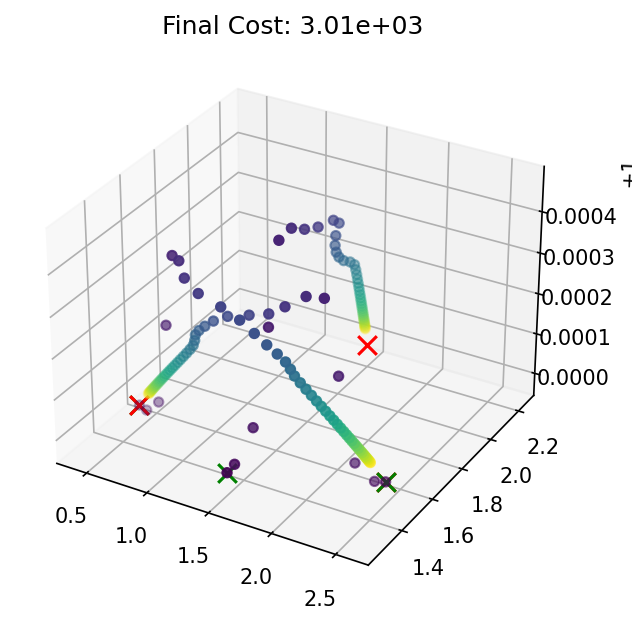

In [67]:
plt.figure(dpi=150)
plot_solve(X, J, xf, x_dims, n_d=3)